#### Binary Classification notebook Overview

##### This comprehensive notebook is part of our Capstone project focusing on classification tasks. It covers data preprocessing, model training and selection, hyperparameter tuning, and model
 ##### evaluation, specifically for binary classification The script includes comprehensive steps for:

##### - **Data Preprocessing**: A custom pipeline handles preprocessing tasks, ensuring the data is ready for model training.

##### - **Model Training and Selection**: A range of classifiers are trained and evaluated with cross-validation. The best model is selected based on the F1 weighted score.

##### - **Hyperparameter Tuning**: We fine-tune the CatBoostClassifier using GridSearchCV to enhance its performance.

##### - **Model Evaluation**: Using the ModelEvaluator class, we assess our model's performance on the test set and visualize the results to gain insights.

##### - **Feature Importance**: The significance of each feature in making predictions is analyzed and visualized to understand the model's behavior.


##### The best model is saved for future prediction tasks, ensuring our work's reproducibility and application in real-world scenarios.

In [ ]:
# import necessary libraries 

import sys
from pathlib import Path
import joblib
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.metrics import (classification_report, roc_auc_score, precision_recall_curve,roc_curve,
                             accuracy_score, confusion_matrix,
                             f1_score,
                             precision_score, recall_score, make_scorer)
from sklearn.model_selection import (GridSearchCV, StratifiedKFold)
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from tempfile import gettempdir
from sklearn.model_selection import  cross_val_predict, cross_validate
# Set the project root path
project_root = Path.cwd().parents[0]
# Insert the project root path to the system path
sys.path.insert(0, str(project_root))
# Import configuration settings
import config
from config import RANDOM_SEED
# Set the random seed
config.set_seed()
# Import our custom utility functions
from utils import DataPreprocessingPipeline
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
# This Python code snippet loads data from a SAS file, preprocesses it, and splits it into training, validation, and testing sets for a machine learning model. 
# It also saves the selected features to a CSV file.

emergency_df = config.load_data('nhamcs14.sas7bdat', 'raw')
target = 'LOV_BINARY'
target_to_drop = ["LOV", 'WAITTIME_BINARY']
pipeline = DataPreprocessingPipeline(
    emergency_df=emergency_df, target=target, target_to_drop=target_to_drop,
    percent_train=0.70, percent_val=0.15, percent_test=0.15, stratify=False
)
pipeline.run()
X_train_preprocessed = pipeline.X_train_preprocessed
X_validation_preprocessed = pipeline.X_validation_preprocessed
X_test_preprocessed = pipeline.X_test_preprocessed
y_train = pipeline.y_train
y_validation = pipeline.y_validation
y_test = pipeline.y_test
feature_names = pipeline.feature_names
cleaned_emergency_df = pipeline.cleaned_emergency_df
transformed_emergency_df = pipeline.transformed_emergency_df
feature_names = [name.replace('num__', '').replace('cat__', '') for name in pipeline.feature_names]
feature_names_list = list(feature_names)
config.save_data(feature_names, f"features_{target}.csv", 'features')

1-Cleaning data...
Data cleaning completed
Size of Initial dataset:(23844, 1012)
Size of cleaned dataset:(19197, 370)

2-Applying feature engineering...
Feature engineering completed
Size of the dataset after feature engineering:(19197, 387)

3-Splitting data...
self.stratify: False
Splitting data completed

4-Loading data...
train_df size: (13437, 387)
X_train size: (13437, 386)
y_train size: (13437,)

validation_df size: (2879, 387)
X_validation size: (2879, 386)
y_validation size: (2879,)

test_df size: (2881, 387)
X_test size: (2881, 386)
y_test size: (2881,)
Loading data completed

5-Preprocessing data...
Preprocessing data completed.
Processor saved successfully


In [3]:
# This function trains and selects the best model based on the provided parameters and scoring metrics.
# It uses cross-validation and SMOTE technique for certain models to handle imbalanced data.
def train_and_select_model(X_train, y_train, models_params, scoring_metrics, cv):
    model_scores = []
    
    for model_name, mp in models_params.items():
        pipeline = ImbPipeline([
            ('smote', SMOTE(random_state=RANDOM_SEED)),
            ('classifier', mp['model'])
        ]) if model_name in ['XGBClassifier', 'LGBMClassifier'] else Pipeline([
            ('classifier', mp['model'])
        ])
        
        scores = cross_validate(pipeline, X_train, y_train, scoring=scoring_metrics, cv=cv, n_jobs=-1, return_train_score=False)
        mean_scores = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring_metrics}
        mean_scores['Model Name'] = model_name
        model_scores.append(mean_scores)
    
    scores_df = pd.DataFrame(model_scores).set_index('Model Name')
    best_model_name = scores_df['f1_weighted'].idxmax()
    
    for model_name in models_params:
        model = models_params[model_name]['model']
        pipeline = ImbPipeline([
            ('smote', SMOTE(random_state=RANDOM_SEED)),
            ('classifier', model)
        ]) if model_name in ['XGBClassifier', 'LGBMClassifier'] else Pipeline([
            ('classifier', model)
        ])
        
        predictions = cross_val_predict(pipeline, X_train, y_train, cv=cv, n_jobs=-1)
        accuracy = accuracy_score(y_train, predictions)
        scores_df.loc[model_name, 'accuracy'] = accuracy
        scores_df.loc[model_name, 'Is Best Model'] = (model_name == best_model_name)
    
    best_pipeline = models_params[best_model_name]['model']
    best_pipeline.fit(X_train, y_train)
    model_filename = f"{best_model_name}_best_model.joblib"
    directory = "/Users/Macbook/Desktop/EDPredictiveEfficiency/notebooks/model_train"
    os.makedirs(directory, exist_ok=True)
    joblib.dump(best_pipeline, os.path.join(directory, model_filename))
    
    print(f"Best model saved: {best_model_name}")
    display(scores_df.sort_values('Is Best Model', ascending=False))
    
    return best_model_name, best_pipeline

In [4]:
# This Python code defines models and their hyperparameters for RandomizedSearchCV for classification modeling.

models_params = {
    'LGBMClassifier': {
        'model': LGBMClassifier(is_unbalance=True, verbose=-1),
        'params': {
            'classifier__max_depth': [3, 4, 5],
            'classifier__learning_rate': [0.01, 0.1],
            'classifier__n_estimators': [100, 200]
        }
    },
    'CatBoostClassifier': {
        'model': CatBoostClassifier(verbose=0),
        'params': {
            'classifier__depth': [3, 4, 5],
            'classifier__learning_rate': [0.01, 0.1],
            'classifier__iterations': [100, 200],
            'classifier__train_dir': [gettempdir()]
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [None, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBClassifier': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'classifier__max_depth': [3, 5, 7],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__n_estimators': [100, 500],
            'classifier__subsample': [0.6, 0.8],
            'classifier__colsample_bytree': [0.6, 0.8]
        }
    },
    'Random Forest Classifier': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [10, 20, None]
        }
    },
    'Gradient Boosting Classifier': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__max_depth': [3, 5, 7]
        }
    },
    'XGBClassifier (Updated)': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'classifier__max_depth': [3, 4, 5],
            'classifier__learning_rate': [0.01, 0.1],
            'classifier__n_estimators': [100, 200]
        }
    },
    'MLPClassifier': {
        'model': MLPClassifier(max_iter=100),
        'params': {
            'classifier__alpha': [0.0001, 0.001, 0.01],
            'classifier__hidden_layer_sizes': [(100,), (50, 50), (100, 50)]
        }
    }
}

In [5]:
# Define scoring metrics
scoring_metrics = {
    'f1_weighted': 'f1_weighted',
    'roc_auc': 'roc_auc',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'accuracy': 'accuracy'
}
# Initialize Stratified K-Folds cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Train and select the best model
best_model_name, best_pipeline = train_and_select_model(X_train_preprocessed, y_train, models_params, scoring_metrics, cv)


/Users/Macbook/Library/Caches/pypoetry/virtualenvs/edpredictiveefficiency-6OWGp70p-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Macbook/Library/Caches/pypoetry/virtualenvs/edpredictiveefficiency-6OWGp70p-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Macbook/Library/Caches/pypoetry/virtualenvs/edpredictiveefficiency-6OWGp70p-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Macbook/Library/Caches/pypoetry/virtualenvs/edpredictiveefficiency-6O

Best model saved: CatBoostClassifier


,f1_weighted,roc_auc,precision,recall,accuracy,Is Best Model
Model Name,,,,,,
CatBoostClassifier,0.824102,0.899426,0.823844,0.824515,0.824514,True
LGBMClassifier,0.822001,0.896185,0.821692,0.822505,0.822505,False
RandomForestClassifier,0.808762,0.875225,0.808898,0.811119,0.812905,False
XGBClassifier,0.815955,0.890675,0.815731,0.816329,0.816328,False
Random Forest Classifier,0.808917,0.876065,0.809026,0.811193,0.811193,False
Gradient Boosting Classifier,0.818160,0.891355,0.817926,0.818561,0.818561,False
XGBClassifier (Updated),0.813654,0.889294,0.813304,0.814244,0.814244,False
MLPClassifier,0.790909,0.860787,0.790529,0.791546,0.788643,False


In [6]:
# This Python code performs hyperparameter tuning for a CatBoostClassifier model using GridSearchCV. 
# It loads a pre-trained model, defines a range of hyperparameters, and searches for the best hyperparameters. 
# The best model is then trained and evaluated on a validation set, with various metrics reported.
# Load the saved best model
model_train_dir = "/Users/Macbook/Desktop/EDPredictiveEfficiency/notebooks/model_train/"
model_filename = "CatBoostClassifier_best_model.joblib"
model_file_path = os.path.join(model_train_dir, model_filename)
trained_model_classification = joblib.load(model_file_path) if os.path.exists(model_file_path) else print(f"No such file found: {model_file_path}")

# Define a range of hyperparameters for CatBoostClassifier
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [200, 300, 400],
    'l2_leaf_reg': [1, 3, 5]
}

# Initialize CatBoostClassifier with auto_class_weights set to 'Balanced'
catboost_model = CatBoostClassifier(random_state=RANDOM_SEED, verbose=0, auto_class_weights='Balanced')

# Configure GridSearchCV
grid_search = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring=make_scorer(f1_score, average='weighted'),
    verbose=1
)

# Perform hyperparameter tuning
print("Starting hyperparameter tuning...")
grid_search.fit(X_train_preprocessed, y_train)

# Retrieve and report the best hyperparameters
best_hyperparams = grid_search.best_params_
print(f"Best hyperparameters: {best_hyperparams}")

# Training the final model with best hyperparameters
best_model = grid_search.best_estimator_

# Evaluate on validation set
y_validation_pred = best_model.predict(X_validation_preprocessed)
y_validation_proba = best_model.predict_proba(X_validation_preprocessed)[:, 1]

# Calculate metrics
f1_validation = f1_score(y_validation, y_validation_pred, average='weighted')
roc_auc_validation = roc_auc_score(y_validation, y_validation_proba)
precision_validation = precision_score(y_validation, y_validation_pred, average='weighted')
recall_validation = recall_score(y_validation, y_validation_pred, average='weighted')

print(f"Validation Metrics:\nF1 (Weighted): {f1_validation:.2f}, ROC AUC: {roc_auc_validation:.2f}, Precision (Weighted): {precision_validation:.2f}, Recall (Weighted): {recall_validation:.2f}")

# Metrics for each class
report = classification_report(y_validation, y_validation_pred, output_dict=True)
print(classification_report(y_validation, y_validation_pred))
for label, metrics in report.items():
    if label not in ('accuracy', 'macro avg', 'weighted avg'):
        print(f"Class {label} - Precision: {metrics['precision']:.2f}, Recall: {metrics['recall']:.2f}, F1-score: {metrics['f1-score']:.2f}")

# Save the best model
path_models = "/Users/Macbook/Desktop/EDPredictiveEfficiency/notebooks/model_train"
model_filename = f"{path_models}/best_lov_classification_catboost_model.joblib"
joblib.dump(best_model, model_filename)
print("best_lov_classification_catboost_model saved")

Starting hyperparameter tuning...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best hyperparameters: {'depth': 6, 'iterations': 400, 'l2_leaf_reg': 5, 'learning_rate': 0.1}
Validation Metrics:
F1 (Weighted): 0.82, ROC AUC: 0.90, Precision (Weighted): 0.82, Recall (Weighted): 0.81
              precision    recall  f1-score   support

         0.0       0.72      0.81      0.76      1058
         1.0       0.88      0.81      0.85      1821

    accuracy                           0.81      2879
   macro avg       0.80      0.81      0.80      2879
weighted avg       0.82      0.81      0.82      2879

Class 0.0 - Precision: 0.72, Recall: 0.81, F1-score: 0.76
Class 1.0 - Precision: 0.88, Recall: 0.81, F1-score: 0.85
best_lov_classification_catboost_model saved


In [10]:
# This is a Python class for evaluating and visualizing machine learning models, specifically for binary classification tasks. 
# It includes methods for evaluating model performance metrics, plotting ROC curve, precision-recall curve, confusion matrix, and feature importances.

class ModelEvaluator:
    def __init__(self, model, X, y, feature_names):
        self.model = model
        self.X = X 
        self.y = y
        self.feature_names = feature_names   
    def evaluate_model(self, X_test, y_test):
            y_pred = self.model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            if hasattr(self.model, 'predict_proba'):
                y_pred_prob = self.model.predict_proba(X_test)[:, 1]
                auc_roc = roc_auc_score(y_test, y_pred_prob)
            else:
                auc_roc = None
            return pd.DataFrame({
                'Accuracy': [accuracy],
                'Precision': [precision],
                'Recall': [recall],
                'F1-score': [f1],
                'AUC-ROC': [auc_roc]
            })
    def plot_roc_curve(self, X_test, y_test):
            if hasattr(self.model, 'predict_proba'):
                y_pred_prob = self.model.predict_proba(X_test)[:, 1]
                fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
                plt.plot(fpr, tpr, label=f'{self.model.__class__.__name__} (AUC = {roc_auc_score(y_test, y_pred_prob):.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve')
            plt.legend()
            plt.show()
    def plot_precision_recall_curve(self, X_test, y_test):
            if hasattr(self.model, 'predict_proba'):
                y_pred_prob = self.model.predict_proba(X_test)[:, 1]
                precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
                plt.plot(recall, precision, label=f'{self.model.__class__.__name__} (AP = {np.trapz(precision, recall):.2f})')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Precision-Recall Curve')
            plt.legend()
            plt.show()
    def plot_confusion_matrix(self, X_test, y_test):
            y_pred = self.model.predict(X_test)
            cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
            plt.title(f'Confusion Matrix for {self.model.__class__.__name__}')
            plt.show()
    def plot_feature_importance(self, best_model, top_n=10):
            if isinstance(best_model, CatBoostClassifier):
                feature_importance_df = pd.DataFrame({
                    'Feature': self.feature_names,
                    'Importance': best_model.feature_importances_
                }).sort_values(by='Importance', ascending=False)
                plt.figure(figsize=(10, 6))
                plt.title(f'Top {top_n} Feature Importances')
                sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n), color='skyblue')
                plt.xlabel('Importance')
                plt.ylabel('Features')
                plt.tight_layout()
                plt.show()

In [11]:
def main():
    # Load the best model (CatBoostClassifier) from the models file
    best_model = joblib.load('/Users/Macbook/Desktop/EDPredictiveEfficiency/notebooks/model_train/best_lov_classification_catboost_model.joblib')

    # Create an instance of the ModelEvaluator with the loaded model
    evaluator = ModelEvaluator(best_model, X_test_preprocessed, y_test, feature_names)

    # Evaluate the model
    results = evaluator.evaluate_model(X_test_preprocessed, y_test)
    print("Model Evaluation Results:")
    print(results)

    # Plot ROC curve
    print("Plotting ROC Curve...")
    evaluator.plot_roc_curve(X_test_preprocessed, y_test)

    # Plot Precision-Recall curve
    print("Plotting Precision-Recall Curve...")
    evaluator.plot_precision_recall_curve(X_test_preprocessed, y_test)

    # Plot confusion matrix
    print("Plotting Confusion Matrix...")
    evaluator.plot_confusion_matrix(X_test_preprocessed, y_test)

    # Plot Feature Importances
    print("Plotting Feature Importances...")
    evaluator.plot_feature_importance(best_model, top_n=10)


Model Evaluation Results:
   Accuracy  Precision    Recall  F1-score   AUC-ROC
0   0.81673   0.884914  0.815833   0.84897  0.897784
Plotting ROC Curve...


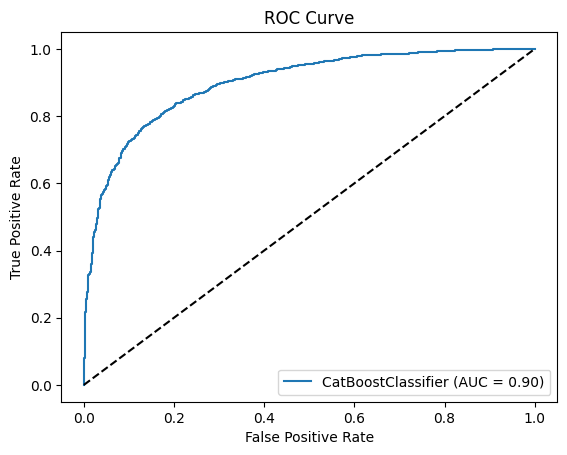

Plotting Precision-Recall Curve...


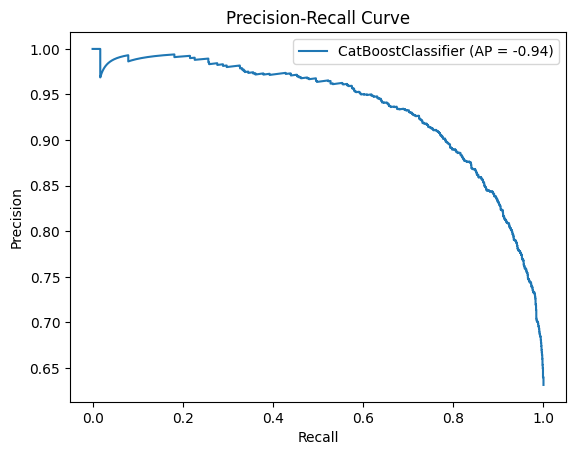

Plotting Confusion Matrix...


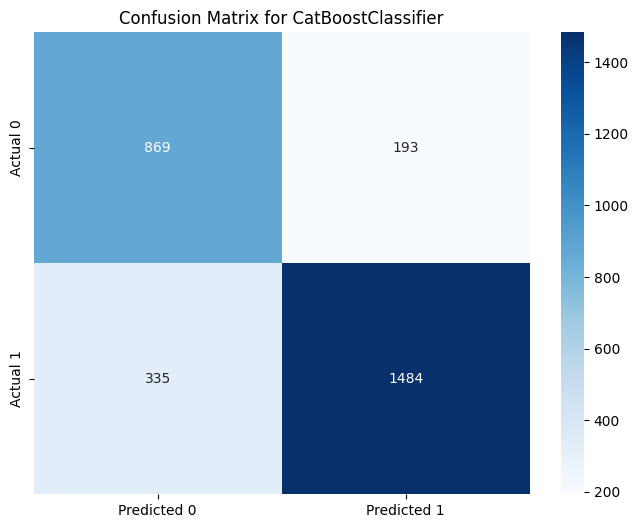

Plotting Feature Importances...


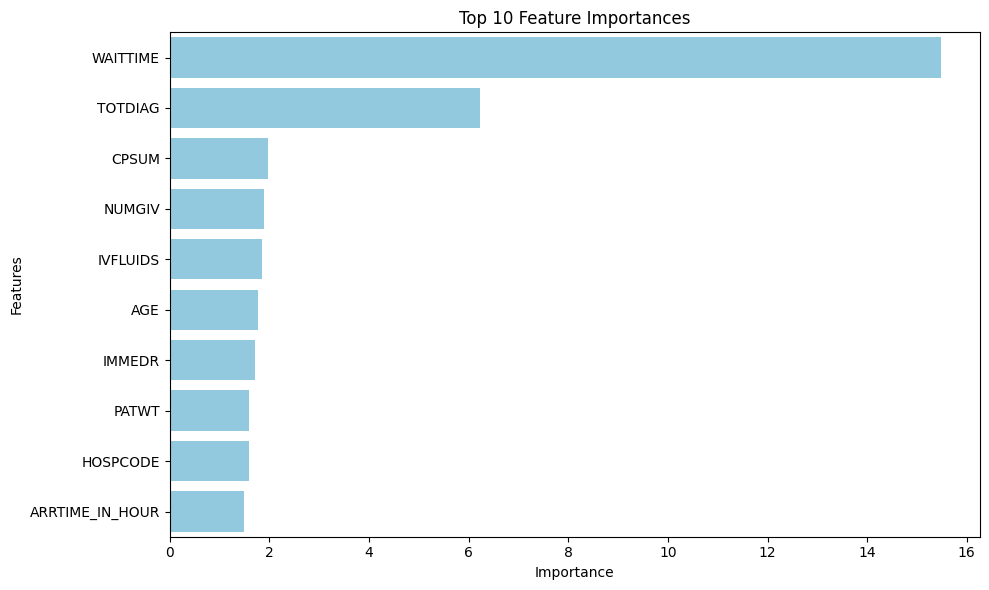

In [12]:
if __name__ == "__main__":
    main()